In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras,re,pickle,string,pickle
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
from keras.preprocessing.text import Tokenizer
from keras.applications.resnet50 import ResNet50,preprocess_input
from IPython.display import clear_output
import collections,random

In [ ]:
with open('Flickr8k_text/Flickr8k.token.txt') as fp:
    token_file = fp.read()
    file_lines = token_file.split('\n')[:-1]

In [ ]:
descriptions = {}

for line in file_lines:
    img_name = line.split('\t')[0].split('.')[0]
    caption = line.split('\t')[1]
    if img_name not in descriptions:
        descriptions[img_name] = list()
    descriptions[img_name].append(caption)

In [ ]:
def clean_line(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]','',text)
    text = [word for word in text.split(' ') if len(word)>2 and word.isalpha()]
    text = " ".join(text)
    return text

In [ ]:
for img_name,cap_list in descriptions.items():
    for count in range(len(cap_list)):
        descriptions[img_name][count] = 'sos ' + descriptions[img_name][count] + ' eos'
        descriptions[img_name][count] = clean_line(descriptions[img_name][count])

In [ ]:
all_cap = list()
for img_name,cap_list in descriptions.items():
    for cap in cap_list:
        all_cap.append(cap)

In [ ]:
train_files = list()
with open('Flickr8k_text/Flickr_8k.trainImages.txt') as fp:
    img_names = fp.read().split('\n')
    for img_name in img_names:
        train_files.append(img_name.split('.')[0])

In [ ]:
test_files = list()
with open('Flickr8k_text/Flickr_8k.testImages.txt') as fp:
    img_names = fp.read().split('\n')
    for img_name in img_names:
        test_files.append(img_name.split('.')[0])

In [ ]:
TL_model = ResNet50(input_shape=(224,224,3))
feature_model = Model(inputs=TL_model.input,outputs=TL_model.layers[-2].output)

In [ ]:
def preprocess_images(img_name):
    img_path = 'Flicker8k_Dataset/' + img_name + '.jpg'
    img = image.load_img(img_path,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    img = preprocess_input(img)
    feature_vector = feature_model.predict(img)
    featuer_vector = feature_vector.reshape(feature_vector.shape[1],)
    return feature_vector[0]

In [1]:
count = 0
train_images = {}
for img_name in train_files:
    count+=1
    train_images[img_name] = preprocess_images(img_name)
    clear_output(wait=True)
    print('images left = ' + str(len(train_files)-count))

NameError: ignored

In [ ]:
count = 0
test_images = {}
for img_name in test_files[:-1]:
    count+=1
    test_images[img_name] = preprocess_images(img_name)
    clear_output(wait=True)
    print('images left = ' + str(len(test_files)-count))

images left = 1


In [ ]:
with open('models/train_image_features.pkl','wb') as fp:
    pickle.dump(train_images,fp)

In [ ]:
with open('models/test_image_features.pkl','wb') as fp:
    pickle.dump(test_images,fp)

In [ ]:
with open('models/train_image_features.pkl','rb') as fp:
    train_images = pickle.load(fp)

In [ ]:
with open('models/test_image_features.pkl','rb') as fp:
    test_images = pickle.load(fp)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_cap)
vocab = tokenizer.word_index
vocab_size = len(vocab) + 1
max_cap_len = max([len(cap.split(' ')) for cap in all_cap])

In [ ]:
encoded_caps = {}
for img_name,cap_list in descriptions.items():
    encoded_cap_list = tokenizer.texts_to_sequences(descriptions[img_name])
    encoded_caps[img_name] = list()
    for count in range(len(cap_list)):
        encoded_caps[img_name].append(encoded_cap_list[count])

In [ ]:
train_dict = {img_name:cap for img_name,cap in encoded_caps.items() if img_name in train_files}
test_dict = {img_name:cap for img_name,cap in encoded_caps.items() if img_name in test_files}

In [ ]:
def data_generator(img_dict,cap_dict,num_img):
    x1,x2,y = list(),list(),list()
    n = 0
    while True:
        for img_name,cap_list in cap_dict.items():
            n += 1
            img_features = img_dict[img_name]
            for cap in cap_list:
                for count in range(1,len(cap)):
                    in_seq = cap[:count]
                    out_seq = cap[count]
                    in_seq = pad_sequences([in_seq],maxlen=max_cap_len,value=0,padding='post')[0]
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    x1.append(img_features)
                    x2.append(in_seq)
                    y.append(out_seq)
            if (n==num_img):
                yield ([np.array(x1),np.array(x2)],np.array(y))
                x1,x2,y = list(),list(),list()
                n = 0

In [ ]:
f = open('glove.6B.50d.txt',encoding='utf8')

In [ ]:
embedding_index = {}
for line in f:
    values = line.split()
    word = values[0]
    coeff = np.asarray(values[1:],dtype='float')
    embedding_index[word] = coeff
f.close()

In [ ]:
def get_embedding_output():
    embed_dim = 50
    embedding_output = np.zeros((vocab_size,embed_dim))
    for word,idx in vocab.items():
        embedding_vector = embedding_index.get(word)
        if (embedding_vector is not None):
            embedding_output[idx] = embedding_vector
    return embedding_output

In [ ]:
embedding_output = get_embedding_output()

In [ ]:
input1 = keras.layers.Input(shape=(2048,))
img_layer1 = keras.layers.Dropout(0.3)(input1)
img_layer2 = keras.layers.Dense(256,activation='relu')(img_layer1)

In [ ]:
input2 = keras.layers.Input(shape=(max_cap_len,))
cap_layer1 = keras.layers.Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input2)
cap_layer2 = keras.layers.Dropout(0.3)(cap_layer1)
cap_layer3 = keras.layers.LSTM(256)(cap_layer2)

In [ ]:
decoder1 = keras.layers.add([img_layer2,cap_layer3])
decoder2 = keras.layers.Dense(256,activation='relu')(decoder1)
OUT = keras.layers.Dense(vocab_size,activation='softmax')(decoder2) 

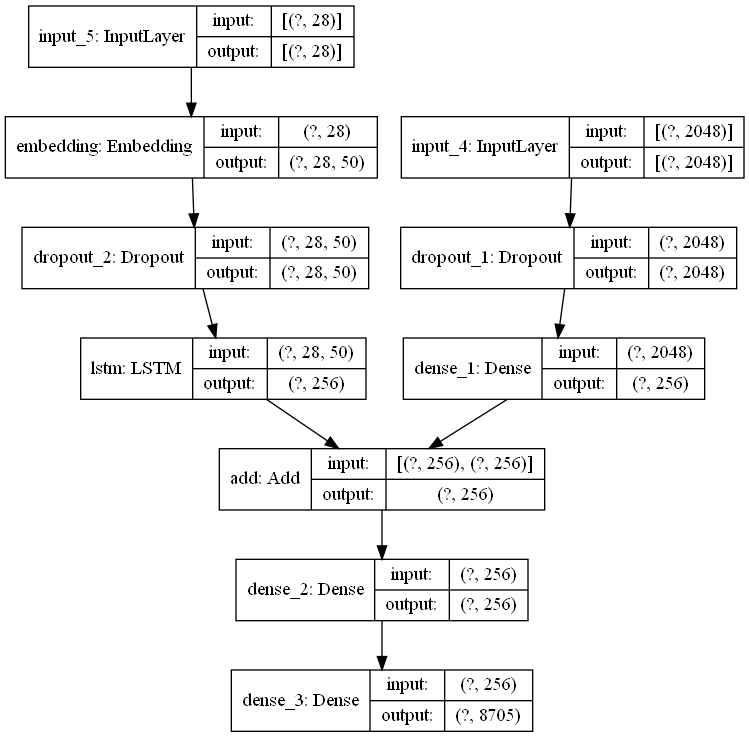

In [ ]:
model = Model(inputs=[input1,input2],outputs=OUT)
plot_model(model,show_shapes=True)

In [ ]:
model.layers[2].set_weights([embedding_output])
model.layers[2].trainable = False

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy')

In [ ]:
EPOCHS = 10
num_pics_per_batch = 3
STEPS = len(train_dict)//num_pics_per_batch

In [ ]:
for i in range(EPOCHS):
    generator = data_generator(train_images,train_dict,num_pics_per_batch)
    model.fit(generator,epochs=1,steps_per_epoch=STEPS)

2000/2000 [==============================] - 446s 223ms/step - loss: 3.0553


In [ ]:
inv_vocab = {idx:word for word,idx in vocab.items()}

In [ ]:
def predict_cap(img_name):
    img_orig_path = 'Flicker8k_Dataset/' + img_name + '.jpg'
    img_orig = image.load_img(img_orig_path)
    if img_name in train_files:
        img_features = train_images[img_name]
    elif img_name in test_files:
        img_features = test_images[img_name]
    img_features = img_features.reshape((1,2048))
    text = 'sos'
    for i in range(max_cap_len):
        seq = tokenizer.texts_to_sequences([text])[0]
        seq = pad_sequences([seq],maxlen=max_cap_len,padding='post')
        ypred = model.predict([img_features,seq])
        ypred = ypred.argmax()
        word = inv_vocab[ypred]
        text += ' ' + word
        if (word=='eos'):
            break
    final_caption = ' '.join(text.split()[1:-1])
    actual_cap = descriptions[img_name][0]
    print('actual caption: ' + str(actual_cap[3:-4]) + '\nfinal caption: ' + str(final_caption))
    plt.imshow(img_orig)

In [ ]:
def inference():
    img_name = random.sample(test_files,1)[0]
    predict_cap(img_name)

actual caption:  black mitsubishi driving through muddy puddle and spraying water
final caption: the vehicle comes off the dirt


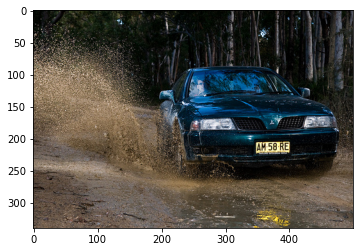

In [ ]:
inference()

In [ ]:
#model.save('models/model1.h5')